### **Logistic_Regression**

In [1]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go

In [2]:
classification = pd.read_csv('https://raw.githubusercontent.com/morn12/tb/main/190%20(1).csv',parse_dates=['Date'])
classification.drop(['Date', 'Hour','SMP','Unnamed: 0'], axis=1, inplace=True)
classification


,Temp,Is_Holiday,Is_Vac,Is_Weekend,Is_Cold,Is_HW,SMP_Above_190
0,24.47,0,1,0,0,0,0
1,24.30,0,1,0,0,0,0
2,24.17,0,1,0,0,0,0
3,23.99,0,1,0,0,0,0
4,23.93,0,1,0,0,0,0
...,...,...,...,...,...,...,...
30708,12.26,0,0,0,0,0,0
30709,12.27,0,0,0,0,0,0
30710,12.06,0,0,0,0,0,0
30711,12.06,0,0,0,0,0,0


###Down Sampling

In [3]:
count_class_0, count_class_1 = classification.SMP_Above_190.value_counts()

# Divide by class
df_class_0 = classification[classification['SMP_Above_190'] == 0]
df_class_1 = classification[classification['SMP_Above_190'] == 1]

In [4]:
df_class_0_under = df_class_0.sample(count_class_1)

# מכן לקיחת מחלקה רנדומלית מהמחלקה הגדולה שהיא בגודל
# המחלקה הקטנה החדשה

df_balanced = pd.concat([df_class_0_under, df_class_1], axis=0)

df_balanced.SMP_Above_190.value_counts()

0    3125
1    3125
Name: SMP_Above_190, dtype: int64

In [5]:
df_balanced.reset_index(drop=True,inplace=True)
df_balanced

,Temp,Is_Holiday,Is_Vac,Is_Weekend,Is_Cold,Is_HW,SMP_Above_190
0,9.94,0,0,1,0,0,0
1,12.73,0,0,0,0,0,0
2,23.51,0,0,0,0,0,0
3,12.90,0,0,1,0,0,0
4,12.80,0,0,1,0,0,0
...,...,...,...,...,...,...,...
6245,19.77,0,0,1,0,0,1
6246,10.81,0,0,0,1,0,1
6247,10.17,0,0,0,1,0,1
6248,8.57,0,0,0,1,0,1


# נרמול עמודת הטמפרטורה

In [6]:
X = df_balanced.drop('SMP_Above_190', axis=1)
y = df_balanced.SMP_Above_190

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(df_balanced[['Temp']]), columns=['Temp'])
scaled_df.head()


,Temp
0,0.154934
1,0.240701
2,0.572087
3,0.245927
4,0.242853


In [8]:
df_balanced.drop(['Temp'],axis=1, inplace=True)
scaled_df = pd.merge(left=scaled_df, right=df_balanced,left_index=True, right_index=True)
X_scaled= pd.DataFrame(scaled_df, columns= scaled_df.columns[0:-1])
X_scaled.head()

,Temp,Is_Holiday,Is_Vac,Is_Weekend,Is_Cold,Is_HW
0,0.154934,0,0,1,0,0
1,0.240701,0,0,0,0,0
2,0.572087,0,0,0,0,0
3,0.245927,0,0,1,0,0
4,0.242853,0,0,1,0,0


# Features Selection

In [9]:
from sklearn.feature_selection import SelectKBest , chi2

In [10]:
chi_selector = SelectKBest(chi2, k=len(X.columns))  # לוקחים את כל העמודות במקום לבחור מספר מסויים
chi_selector.fit(X, y)

scores = pd.Series(chi_selector.scores_.tolist()) 
p_values = pd.Series(chi_selector.pvalues_.tolist())  # יראה ערכי פי ואליו

selected_df = round(pd.DataFrame({'univariate_score':scores, 'p_values':p_values}),3)
selected_df.set_index(X.columns, inplace=True, drop=True)
univariate_df = selected_df.sort_values(by='univariate_score', ascending=False)
univariate_df
# מראה בטבלה דירוג של הפיצרים מהכי טוב לפחות
# צריך פי ואליו כמה שיותר נמוך (מתחת ל 0.05)
# בחרנו לא להסיר פיצרים מאחר ויש לנו מעט

,univariate_score,p_values
Temp,2555.230,0.000
Is_Vac,371.873,0.000
Is_HW,117.386,0.000
Is_Cold,52.364,0.000
Is_Holiday,12.165,0.000
Is_Weekend,6.970,0.008


In [11]:
from xgboost import XGBClassifier
# יבנה עצי החלטה שידרגו פיצרים הכי חזקים

In [12]:
model = XGBClassifier()
model.fit(X,y)
feat_importances_df = pd.DataFrame({'feature_importance':model.feature_importances_}, index=X.columns)
feat_importances_df=feat_importances_df.sort_values(by='feature_importance', ascending=False)
feat_importances_df
# בחרנו לא להסיר פיצרים מאחר ויש לנו מעט

,feature_importance
Temp,0.372544
Is_HW,0.183365
Is_Vac,0.148255
Is_Holiday,0.138390
Is_Weekend,0.109140
Is_Cold,0.048306


In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=1234)
train_df = pd.merge(left=X_train, right=y_train, left_index=True, right_index=True)
test_df = pd.merge(left=X_test, right=y_test, left_index=True, right_index=True)
train_df.head(10)

,Temp,Is_Holiday,Is_Vac,Is_Weekend,Is_Cold,Is_HW,SMP_Above_190
3377,0.630495,0,1,0,0,1,1
3533,0.611436,0,1,0,0,0,1
4320,0.660006,0,1,0,0,1,1
3351,0.624347,0,1,0,0,1,1
3593,0.697510,0,1,1,0,0,1
3096,0.480787,0,0,1,0,0,0
2405,0.271749,0,0,1,0,0,0
3162,0.613895,0,1,0,0,0,1
28,0.318783,0,0,1,0,0,0
1686,0.274823,0,0,0,0,0,0


In [14]:
correlated = classification.columns.tolist() # מערך של עמודות הטבלה
correlated = correlated[:-1] # פיצרים ללא עמודת המטרה

# מודל רגרסיה לוגיסטית

In [15]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
# The coefficients
coeff = logmodel.coef_[0]
intercept = logmodel.intercept_[0]
print('Coefficients: \n', "coeff =", coeff , ",  Intercept=",intercept,"\n" )
print("The regression equation is:" ,"SMP = " ,intercept," + ",coeff[0]," * ",correlated[0]," + ",coeff[1]," * ",correlated[1]," + ",coeff[2]," * ",correlated[2], " + ",coeff[3]," * ",correlated[3]," + ",coeff[4]," * ",correlated[4]," + ",coeff[5]," * ",correlated[5])

# ניתן לראות שפיצר הטמפרטורה הוא בעל ההשפעה הרבה ביותר

Coefficients: 
 coeff = [ 5.9510788   0.58645319  0.63297744 -0.15392208  1.32057876 -0.52737402] ,  Intercept= -3.3592080188988502 

The regression equation is: SMP =  -3.3592080188988502  +  5.951078804194373  *  Temp  +  0.5864531899262513  *  Is_Holiday  +  0.6329774414053957  *  Is_Vac  +  -0.15392208233270258  *  Is_Weekend  +  1.3205787624098386  *  Is_Cold  +  -0.5273740213926944  *  Is_HW


In [16]:
# מראה את תוצאות החיזוי ואת התוצאות האמיתיות
probability = logmodel.predict_proba(X_train)
prediction = logmodel.predict(X_train)

y_train_prob_0 = pd.Series(probability[:,0], name ='probability_0', index=y_train.index)
y_train_prob_1 = pd.Series(probability[:,1], name ='probability_1', index=y_train.index)
y_train_pred   = pd.Series(prediction      , name ='prediction'   , index=y_train.index)

train_results = pd.DataFrame(data={'probability_0':y_train_prob_0, 'probability_1':y_train_prob_1,'prediction':y_train_pred, 'actual':y_train})
train_results

,probability_0,probability_1,prediction,actual
3377,0.377888,0.622112,1,1
3533,0.286494,0.713506,1,1
4320,0.337570,0.662430,1,1
3351,0.386528,0.613472,1,1
3593,0.219123,0.780877,1,1
...,...,...,...,...
664,0.781372,0.218628,0,0
3276,0.361573,0.638427,1,1
1318,0.923970,0.076030,0,0
723,0.791811,0.208189,0,0


In [17]:
correct_rows = len(train_results.loc[train_results.prediction == train_results.actual])
accuracy = round(correct_rows/len(train_results),2)
print(str(accuracy) + '%')
#בכמה המודל צדק

0.73%


In [18]:
probability = logmodel.predict_proba(X_test)
prediction = logmodel.predict(X_test) 
y_test_prob_0 =pd.Series(probability[:,0], name='probability_0', index=y_test.index)
y_test_prob_1 =pd.Series(probability[:,1], name='probability_1', index=y_test.index)
y_test_pred = pd.Series(prediction, name='prediction', index=y_test.index)

test_results = pd.DataFrame(data={'probability_0':y_test_prob_0, 'probability_1':y_test_prob_1,'prediction':y_test_pred, 'actual':y_test})
test_results

,probability_0,probability_1,prediction,actual
1583,0.333491,0.666509,1,0
4168,0.212398,0.787602,1,1
4194,0.324150,0.675850,1,1
3947,0.165647,0.834353,1,1
193,0.313764,0.686236,1,0
...,...,...,...,...
3663,0.447370,0.552630,1,1
3827,0.386528,0.613472,1,1
4655,0.299760,0.700240,1,1
4751,0.517017,0.482983,0,1


## הערכת המודל

In [19]:
from sklearn import metrics
y_test_pred = test_results.prediction
confusion = metrics.confusion_matrix(y_test, y_test_pred)
#slice into four pieces
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

confusion
# המודל חזק יותר בחיזויים של 1

array([[644, 314],
       [222, 695]])

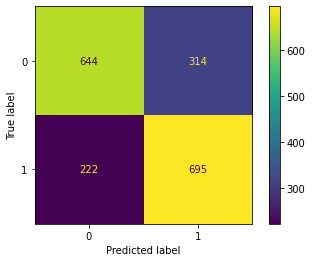

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion, display_labels=logmodel.classes_)
disp.plot()

In [21]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_test_pred))
# ערכים שאינם גבוהים מספיק

              precision    recall  f1-score   support

           0       0.74      0.67      0.71       958
           1       0.69      0.76      0.72       917

    accuracy                           0.71      1875
   macro avg       0.72      0.72      0.71      1875
weighted avg       0.72      0.71      0.71      1875



In [22]:
y_pred_prob = test_results.probability_1 # עמודה שמחזיקה חיזויים לקבלת אחד
fp_rate, tp_rate, thresholds = metrics.roc_curve(y_test, y_pred_prob)


In [23]:
fig=go.Figure()
trace=go.Scatter(x=fp_rate, y=tp_rate, mode='lines', hoverinfo='x+y+text', text=thresholds)
fig.add_trace(trace)
fig.update_layout(
    title="ROC curve for diabetes classifier",
    xaxis_title="False Positive Rate (1 - Specificity)",
    yaxis_title="True Positive Rate (Sensitivity/Recall)",
    
)
fig.show()

# צד ימין של הערכים על הקו זה הריקול ושמאל זה הטעות

In [24]:
AUC = metrics.roc_auc_score(y_test, y_pred_prob)
print('AUC',AUC)
# רמת דיוק לא מספיק גבוהה

AUC 0.7671345929246454


##Cross Validation

In [25]:
# calculate cross-validated AUC
# רלוונטי בעיקר למודלים קטנים עם קצת נתונים
from sklearn.model_selection import cross_val_score
auc_scores = cross_val_score(logmodel, X_scaled, y, cv=10, scoring='roc_auc') #f1_score, recall, presicion שיטת ניקוד
# הפונקציה מקבלת את המודל שלנו, טבלה שלנו, וואי ואת כמות הקבוצות
auc_scores

array([0.88062689, 0.85380315, 0.85884636, 0.83109077, 0.85870812,
       0.71092918, 0.77270214, 0.6570564 , 0.52659335, 0.48725629])

In [26]:
accuracy_scores = cross_val_score(logmodel, X_scaled, y, cv=10, scoring='accuracy') 
accuracy_scores

array([0.8256, 0.8224, 0.8192, 0.7696, 0.8064, 0.6464, 0.6736, 0.5632,
       0.3952, 0.5296])

In [27]:
print('Mean values')
print('auc:', auc_scores.mean())
print('accuracy: ', accuracy_scores.mean()) 
# מאחר והרמת דיוק עדיין לא גבוה מספיק, נבחר שלא להשתמש במודל זה לצורך מחקרינו

Mean values
auc: 0.7437612640288359
accuracy:  0.6851200000000001
